In [1]:
# The MIT License (MIT) Copyright (c) 2025 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in the Software without
# restriction, including without limitation the rights to use, copy, modify, merge, publish,
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/07_MLP_torch.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# MLP

- Dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

In [2]:
import torch

torch.__version__

'2.5.1+cu124'

In [3]:
import pandas as pd
import string

# Lee los archivos CSV
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

# Asigna la clase a cada DataFrame
fake_df['class'] = 1
true_df['class'] = 0

# Concatena los DataFrames
df = pd.concat([fake_df, true_df], ignore_index=True)
df['title_text'] = df['title'] + ' ' + df['text']

# Muestra el DataFrame resultante (opcional)
df.head()

,title,text,subject,date,class,title_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,Pope Francis Just Called Out Donald Trump Dur...


In [4]:
df.tail()

,title,text,subject,date,class,title_text
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0,'Fully committed' NATO backs new U.S. approach...
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0,LexisNexis withdrew two products from Chinese ...
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0,Minsk cultural hub becomes haven from authorit...
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0,Vatican upbeat on possibility of Pope Francis ...
44897,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",0,Indonesia to buy $1.14 billion worth of Russia...


In [5]:
from sklearn.model_selection import train_test_split

X = df['title_text']
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train and 20% test
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (35918,), Test shape: (8980,)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

input_dim = 10000
tfidf_vectorizer = TfidfVectorizer(
    max_features=input_dim,
)
# Ajusta y transforma el conjunto de entrenamiento
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transforma el conjunto de prueba
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")

X_train_tfidf shape: (35918, 10000)
X_test_tfidf shape: (8980, 10000)


In [7]:
# MEMORY EFFICIENT DATALOADER
from torch.utils.data import Dataset

class SparseDataset(Dataset):
    def __init__(self, X_sparse, y):
        self.X_sparse = X_sparse
        self.y = y
    
    def __len__(self):
        return self.X_sparse.shape[0]
    
    def __getitem__(self, idx):
        X_i = torch.FloatTensor(self.X_sparse[idx].toarray()[0])
        y_i = torch.tensor(self.y[idx], dtype=torch.long)
        return X_i, y_i

# Create datasets without converting the whole matrix
#train_dataset = SparseDataset(X_train_tfidf, y_train.values)
#test_dataset = SparseDataset(X_test_tfidf, y_test.values)

In [8]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example to check the shape
test_batch, test_label = next(iter(train_loader))
print(test_batch.shape, test_label.shape)

torch.Size([32, 10000]) torch.Size([32])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = (self.fc2(x))
        return x

net = MLP(input_dim, 3, 1)
test_out = net(test_batch)
test_out.shape, test_label.shape

(torch.Size([32, 1]), torch.Size([32]))

In [10]:
import torch.optim as optim 

optimizer = optim.SGD(net.parameters(), lr=0.01) 
criterion = nn.MSELoss() # requires float32

#criterion = nn.CrossEntropyLoss()

In [11]:
criterion(test_out.squeeze(), test_label)

tensor(0.2500, grad_fn=<MseLossBackward0>)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [13]:
net.to(device)

MLP(
  (fc1): Linear(in_features=10000, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=1, bias=True)
)

In [14]:
import time

train_loss_history = []
train_acc_history = []

test_loss_history = []
test_acc_history = []

In [15]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels) # mse requires float32
        loss.backward()
        optimizer.step()

        # metrics
        pred = (outputs > 0.5)
        running_acc += (pred == labels).sum().item()
        running_loss += loss.item()


    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader.dataset)
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec '
          f'Train loss: {epoch_loss:.4f}')
    print(f'Train acc: {epoch_acc:.4f}')

#train(net, device, train_loader, optimizer, 10)

In [16]:
def test(model, device, test_loader):
    start = time.time()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels) # mse requires float32
            pred = (outputs > 0.5)
            running_acc += (pred == labels).sum().item()
            running_loss += loss.item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = running_acc / len(test_loader.dataset)
    test_loss_history.append(epoch_loss)
    test_acc_history.append(epoch_acc)

    print(f'Time for eval is {time.time()-start:.4f} sec '
          f'Val loss: {epoch_loss:.4f}')
    print(f'Val acc: {epoch_acc:.4f}')

#test(net, device, test_loader)

In [17]:
epochs = 7

for epoch in range(epochs):
    train(net, device, train_loader, optimizer, epoch)
    test(net, device, test_loader)


Time for epoch 0 is 1.2547 sec Train loss: 0.2378
Train acc: 0.6474
Time for eval is 0.1855 sec Val loss: 0.2202
Val acc: 0.8486

Time for epoch 1 is 1.1677 sec Train loss: 0.1871
Train acc: 0.9135
Time for eval is 0.1856 sec Val loss: 0.1465
Val acc: 0.9391

Time for epoch 2 is 1.1467 sec Train loss: 0.1070
Train acc: 0.9440
Time for eval is 0.1902 sec Val loss: 0.0787
Val acc: 0.9509

Time for epoch 3 is 1.1054 sec Train loss: 0.0628
Train acc: 0.9558
Time for eval is 0.1886 sec Val loss: 0.0535
Val acc: 0.9611

Time for epoch 4 is 1.0917 sec Train loss: 0.0462
Train acc: 0.9659
Time for eval is 0.1915 sec Val loss: 0.0429
Val acc: 0.9677

Time for epoch 5 is 1.1445 sec Train loss: 0.0383
Train acc: 0.9721
Time for eval is 0.2020 sec Val loss: 0.0371
Val acc: 0.9736

Time for epoch 6 is 1.1917 sec Train loss: 0.0336
Train acc: 0.9767
Time for eval is 0.1870 sec Val loss: 0.0335
Val acc: 0.9767


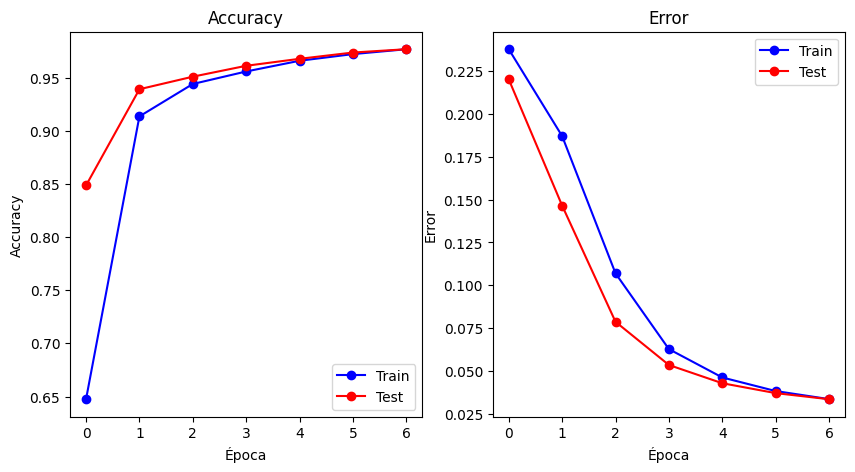

In [18]:
import matplotlib.pyplot as plt
# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot de accuracy en el primer subplot
ax1.plot(train_acc_history, 'bo-', label='Train')
ax1.plot(test_acc_history, 'ro-', label='Test')
ax1.set_title('Accuracy')
ax1.set_xlabel('Época')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot de error en el segundo subplot
ax2.plot(train_loss_history, 'bo-', label='Train')
ax2.plot(test_loss_history, 'ro-', label='Test')
ax2.set_title('Error')
ax2.set_xlabel('Época')
ax2.set_ylabel('Error')
ax2.legend()

# Mostrar figura
plt.show()